In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
from ae import Autoencoder
import matplotlib.pyplot as plt
from utils import display_examples, display_latents

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), # Convert PIL image to tensor and scale to [0, 1]
])

## Downloading the MNIST dataset

In [3]:
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Download and load the MNIST test dataset
test_dataset = datasets.MNIST(
    root='./data',
    train=False,          # Load test set
    download=True,
    transform=transform
)

## Creating dataloaders and displaying sample image

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verify the download by printing some info
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Visualize a sample image
sample_image, sample_label = train_dataset[0]  # Get the first image and label
print(f"Sample image shape: {sample_image.shape}")  # Should be [1, 28, 28]
print(f"Sample label: {sample_label}")

Training set size: 60000
Test set size: 10000
Sample image shape: torch.Size([1, 28, 28])
Sample label: 5


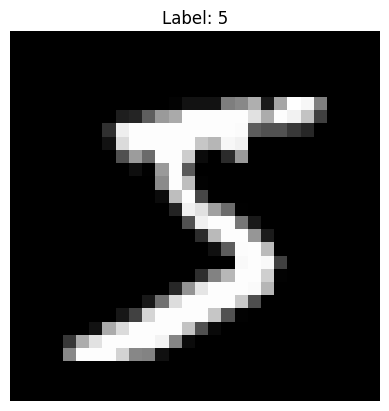

In [5]:
# Plot the sample image
plt.imshow(sample_image.squeeze(), cmap='gray')  # Squeeze removes the channel dim for plotting
plt.title(f"Label: {sample_label}")
plt.axis('off')  # Hide axes
plt.show()

## Declarations

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

convChannels = (1, 4, 4, 4, 4)
convKernels =   (3, 3, 2, 2)
convStrides =   (1, 1, 2, 2)
convPadding =   (1, 1, 0, 0)

# AutoEncoder
ae = Autoencoder(2, sample_image.shape, convChannels, convKernels, convStrides, convPadding).to(device)

# Loss function and optimizer
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

## Main Training Loop

In [7]:
losses = []
iterations = []
max_epochs = 50

ae.train()
for epoch in range(max_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # Move images to GPU
        images = images.to(device)

        # Forward and backward pass
        optimizer.zero_grad()
        outputs = ae(images)
        latents = ae.latent # N x 2 tensor
        loss = mse_loss(outputs, images)
        loss.backward()
        optimizer.step()

        if i == 0:
            print(f"Epoch: {epoch}, Loss: {loss.detach()}")

torch.save(ae.state_dict(), './models/ae.pth')
print(f"Final Loss: {loss.detach()}")

Epoch: 0, Loss: 0.3200142979621887
Epoch: 1, Loss: 0.05534873157739639
Epoch: 2, Loss: 0.0537433996796608
Epoch: 3, Loss: 0.05419383943080902
Epoch: 4, Loss: 0.05323036387562752
Epoch: 5, Loss: 0.056815240532159805
Epoch: 6, Loss: 0.047728750854730606
Epoch: 7, Loss: 0.04953688383102417
Epoch: 8, Loss: 0.05056435614824295
Epoch: 9, Loss: 0.05442825332283974
Epoch: 10, Loss: 0.047478705644607544
Epoch: 11, Loss: 0.05325143411755562
Epoch: 12, Loss: 0.04751357063651085
Epoch: 13, Loss: 0.04898626357316971
Epoch: 14, Loss: 0.04653913155198097
Epoch: 15, Loss: 0.050846584141254425
Epoch: 16, Loss: 0.05129368230700493
Epoch: 17, Loss: 0.04753755033016205
Epoch: 18, Loss: 0.04723075404763222
Epoch: 19, Loss: 0.05150987580418587
Epoch: 20, Loss: 0.04868467524647713
Epoch: 21, Loss: 0.04921460524201393
Epoch: 22, Loss: 0.0503629706799984
Epoch: 23, Loss: 0.0517302043735981
Epoch: 24, Loss: 0.054427340626716614
Epoch: 25, Loss: 0.047254376113414764
Epoch: 26, Loss: 0.05189541354775429
Epoch: 27

## Displaying Examples

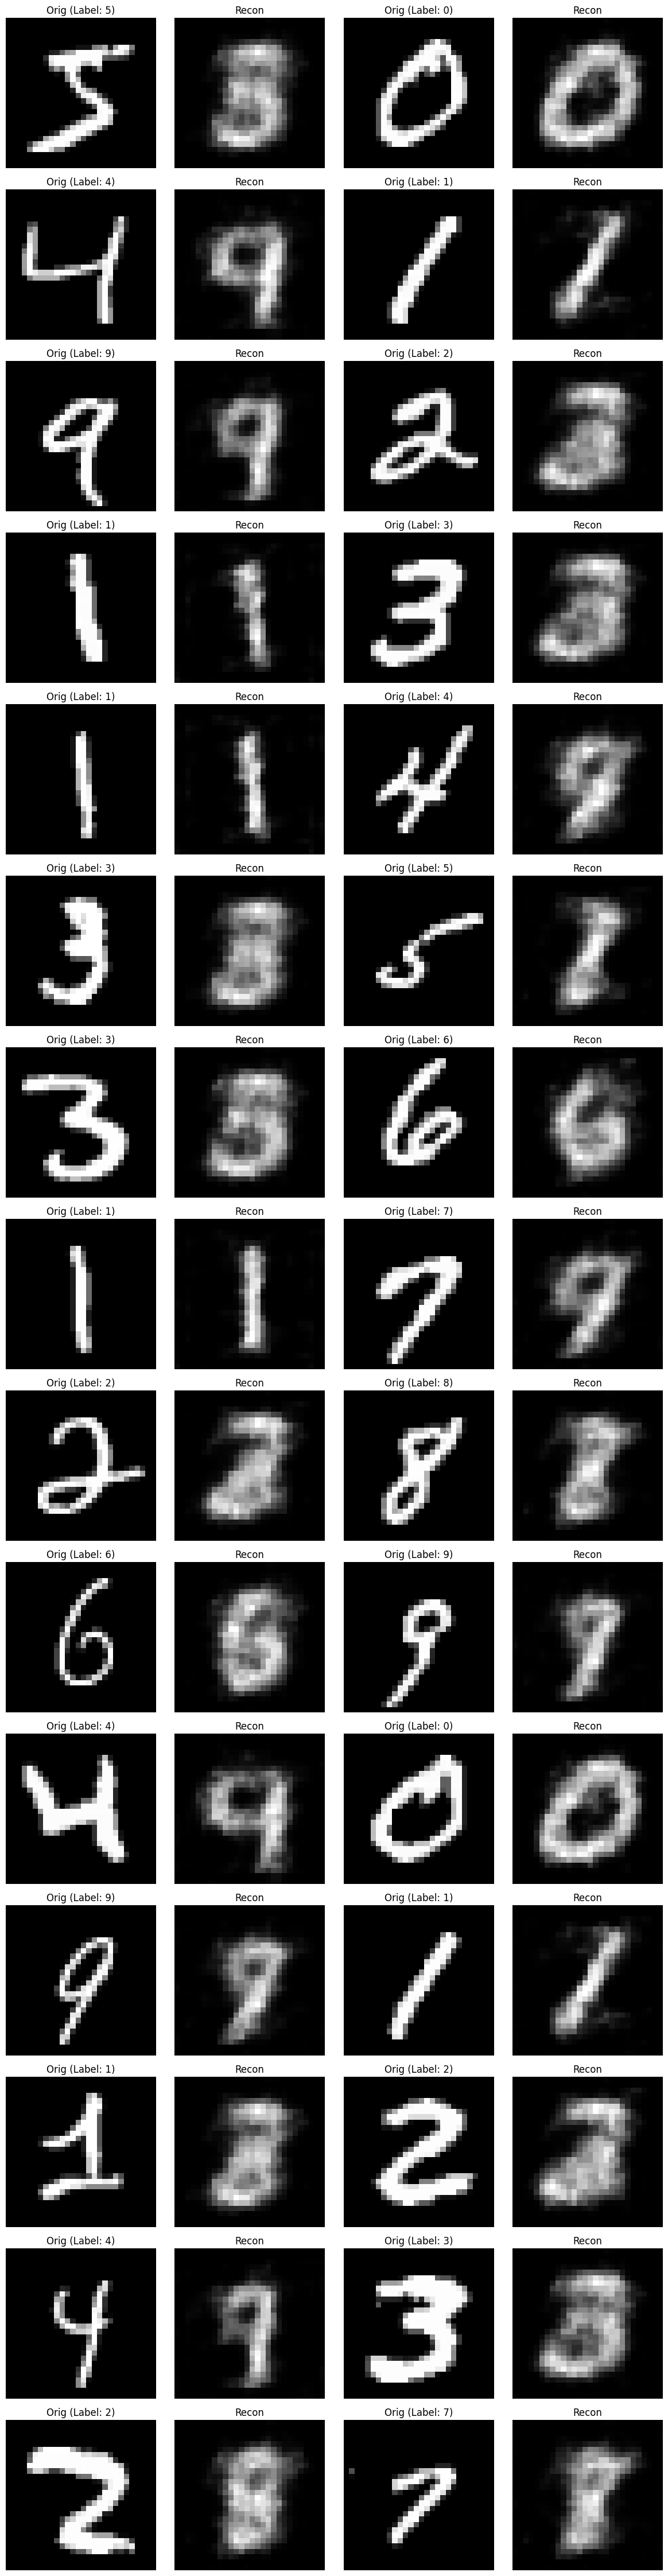

In [14]:
ae = ae = Autoencoder(2, sample_image.shape, convChannels, convKernels, convStrides, convPadding).to(device)
ae.load_state_dict(torch.load('models/ae.pth', weights_only=True))
display_examples(ae, train_dataset, device)

## Visualizing Latent Space

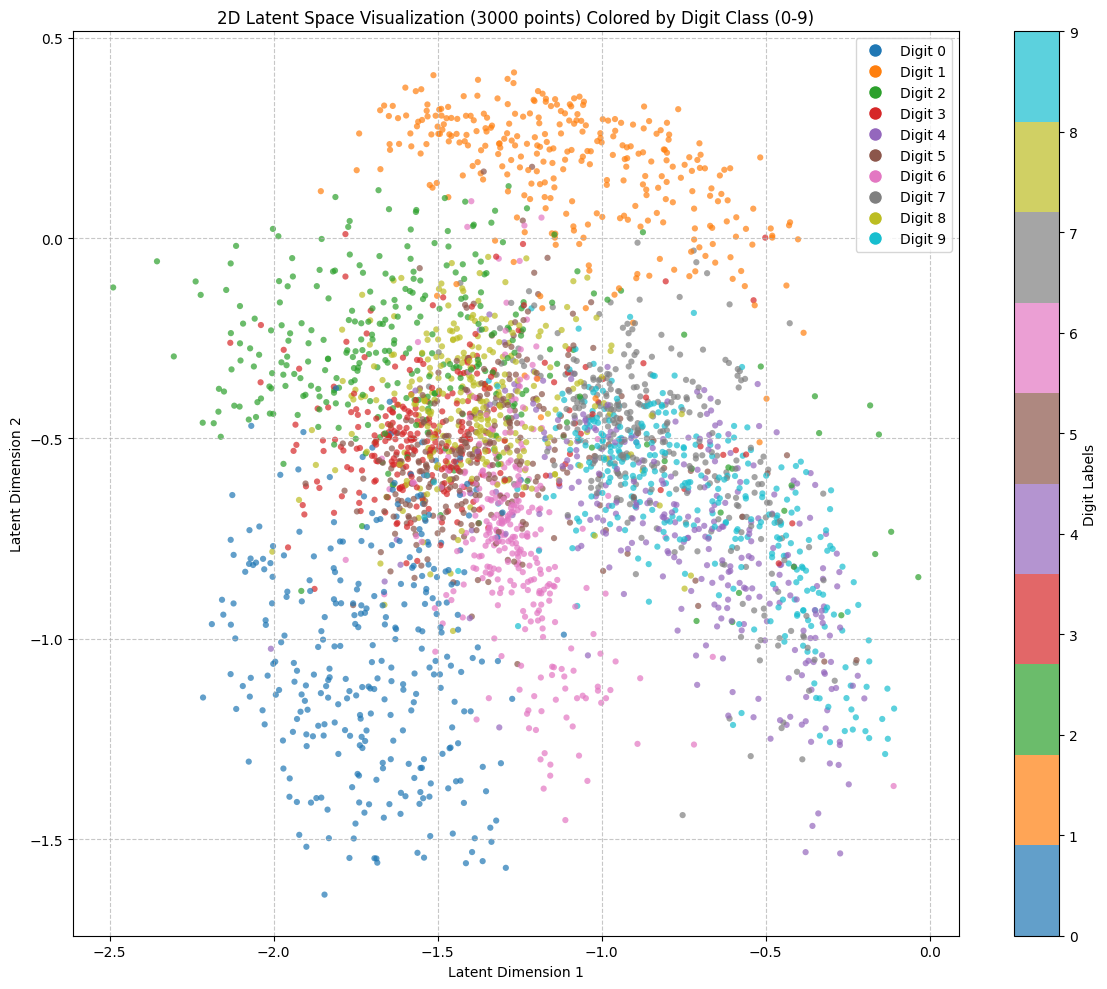

In [16]:
display_latents(ae, train_loader, device)

## Contrastive Loss
It feels intuitive that contrastive loss should increase performance. All of the space of R^2 exists for the latent space, yet there is a lot of overlap between different labels in the space.

However this might reduce reconstruction quality as reconstructing the correct number will be prioritized over encoding features of the drawing reducing fidelity.

In [17]:
def contrastive_loss(latents, labels, temperature=0.5):
    batch_size = latents.size(0)

    # Normalize the latents for cosine similarity
    latents = F.normalize(latents, p=2, dim=1)

    # Compute similarity matrix (N x N)
    sim_matrix = torch.matmul(latents, latents.T) / temperature

    # Create label mask
    labels = labels.unsqueeze(1)  # Shape: (N, 1)
    mask = torch.eq(labels, labels.T).float().to(latents.device)

    # Positive and negative masks
    pos_mask = mask - torch.eye(batch_size).to(latents.device)  # Exclude self-comparison

    # Logits: positive pairs vs all pairs
    exp_sim = torch.exp(sim_matrix)
    log_prob = sim_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True))

    # Contrastive loss: average over positive pairs
    contrastive_loss = -(log_prob * pos_mask).sum() / pos_mask.sum()
    return contrastive_loss

In [38]:
# AutoEncoder
aeWithContrastiveLoss = Autoencoder(2, sample_image.shape, convChannels, convKernels, convStrides, convPadding).to(device)
optimizerWithContrastiveLoss = torch.optim.Adam(aeWithContrastiveLoss.parameters(), lr=0.001)

## Training Loop With Contrastive Loss

In [39]:
lambda_contrastive = 1  # Weighting factor for contrastive loss

losses = []
iterations = []
max_epochs = 50

aeWithContrastiveLoss.train()
for epoch in range(max_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # Move to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizerWithContrastiveLoss.zero_grad()
        outputs = aeWithContrastiveLoss(images)
        latents = aeWithContrastiveLoss.latent  # N x 2 tensor

        # Compute losses
        reconstruction_loss = mse_loss(outputs, images)
        cont_loss = contrastive_loss(latents, labels)

        loss = reconstruction_loss + lambda_contrastive * cont_loss

        # Backward pass
        loss.backward()
        optimizerWithContrastiveLoss.step()

        if i == 0:
            print(f"Epoch: {epoch}, Recon Loss: {reconstruction_loss.item():.4f}, Contrastive Loss: {cont_loss.item():.4f}, Total Loss: {loss.item():.4f}")

torch.save(aeWithContrastiveLoss.state_dict(), './models/aeContrastive.pth')
print(f"Final Loss: {loss.detach()}")

Epoch: 0, Recon Loss: 0.1707, Contrastive Loss: 4.4696, Total Loss: 4.6403
Epoch: 1, Recon Loss: 0.0580, Contrastive Loss: 3.3797, Total Loss: 3.4377
Epoch: 2, Recon Loss: 0.0611, Contrastive Loss: 3.4134, Total Loss: 3.4745
Epoch: 3, Recon Loss: 0.0594, Contrastive Loss: 3.3493, Total Loss: 3.4087
Epoch: 4, Recon Loss: 0.0556, Contrastive Loss: 3.3128, Total Loss: 3.3683
Epoch: 5, Recon Loss: 0.0593, Contrastive Loss: 3.3221, Total Loss: 3.3815
Epoch: 6, Recon Loss: 0.0584, Contrastive Loss: 3.2909, Total Loss: 3.3493
Epoch: 7, Recon Loss: 0.0548, Contrastive Loss: 3.3155, Total Loss: 3.3702
Epoch: 8, Recon Loss: 0.0577, Contrastive Loss: 3.2655, Total Loss: 3.3232
Epoch: 9, Recon Loss: 0.0597, Contrastive Loss: 3.1217, Total Loss: 3.1814
Epoch: 10, Recon Loss: 0.0572, Contrastive Loss: 3.2671, Total Loss: 3.3243
Epoch: 11, Recon Loss: 0.0572, Contrastive Loss: 3.2214, Total Loss: 3.2786
Epoch: 12, Recon Loss: 0.0535, Contrastive Loss: 3.3591, Total Loss: 3.4126
Epoch: 13, Recon Loss:

## Displaying Examples with Contrastive Loss

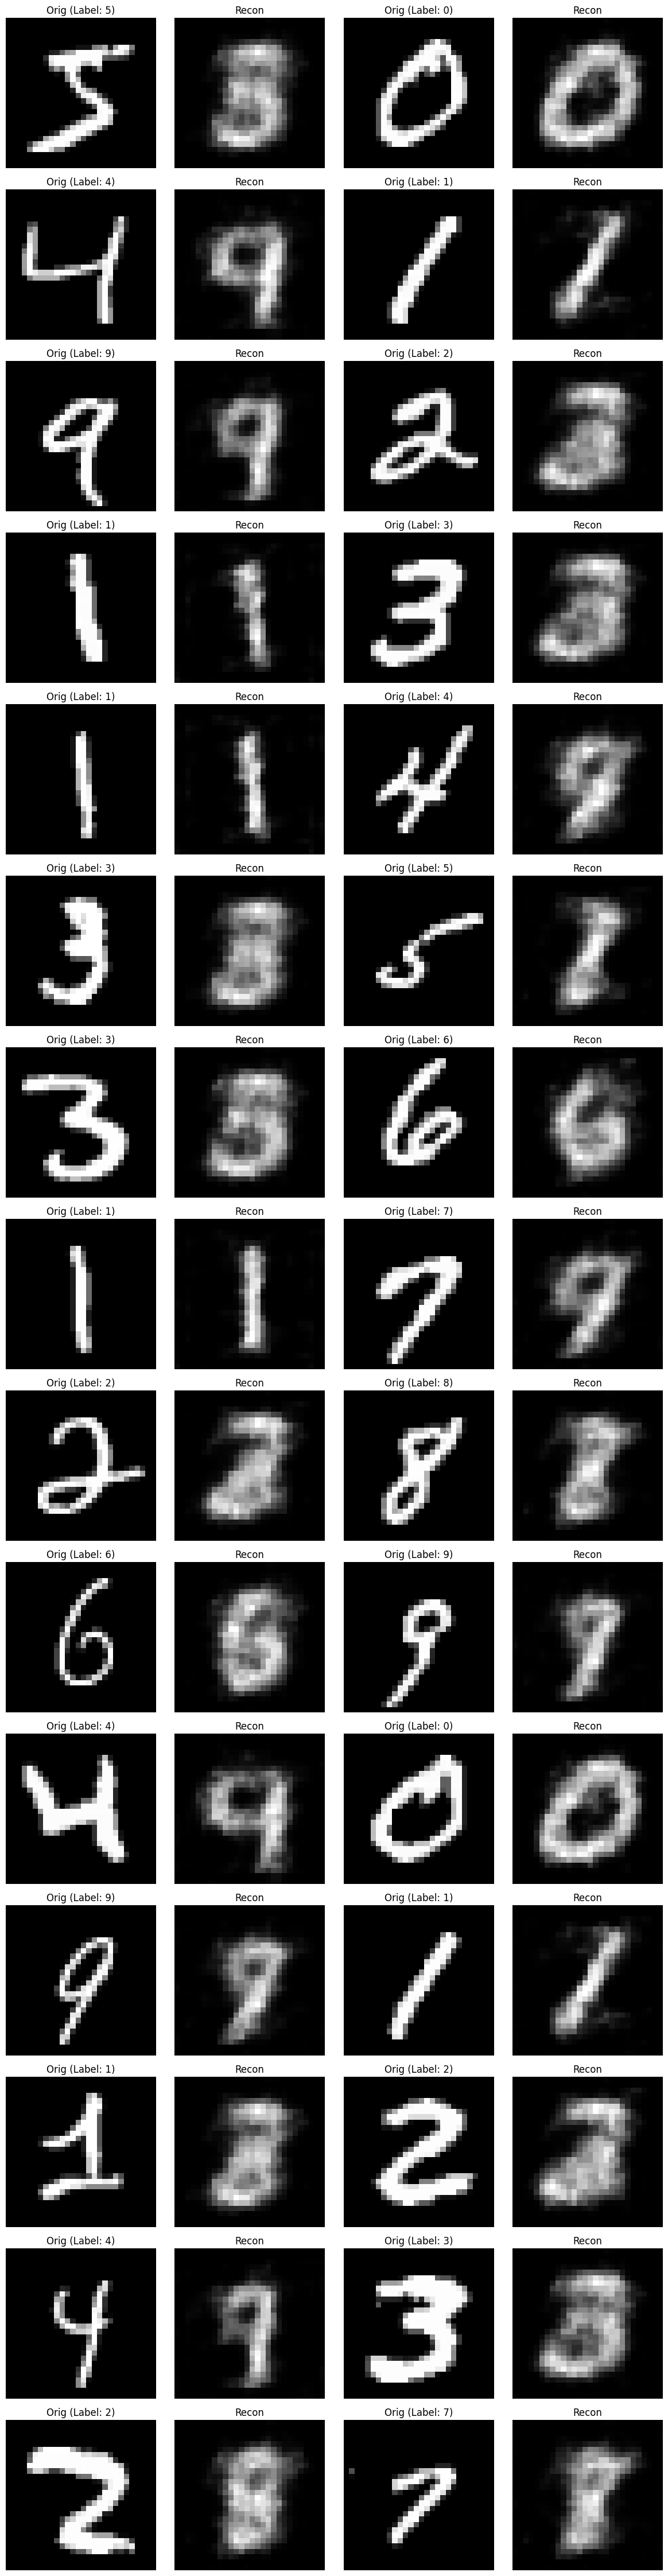

In [43]:
aeWithContrastiveLoss = Autoencoder(2, sample_image.shape, convChannels, convKernels, convStrides, convPadding).to(device)
aeWithContrastiveLoss.load_state_dict(torch.load('./models/aeContrastive.pth', weights_only=True))
display_examples(ae, train_dataset, device)

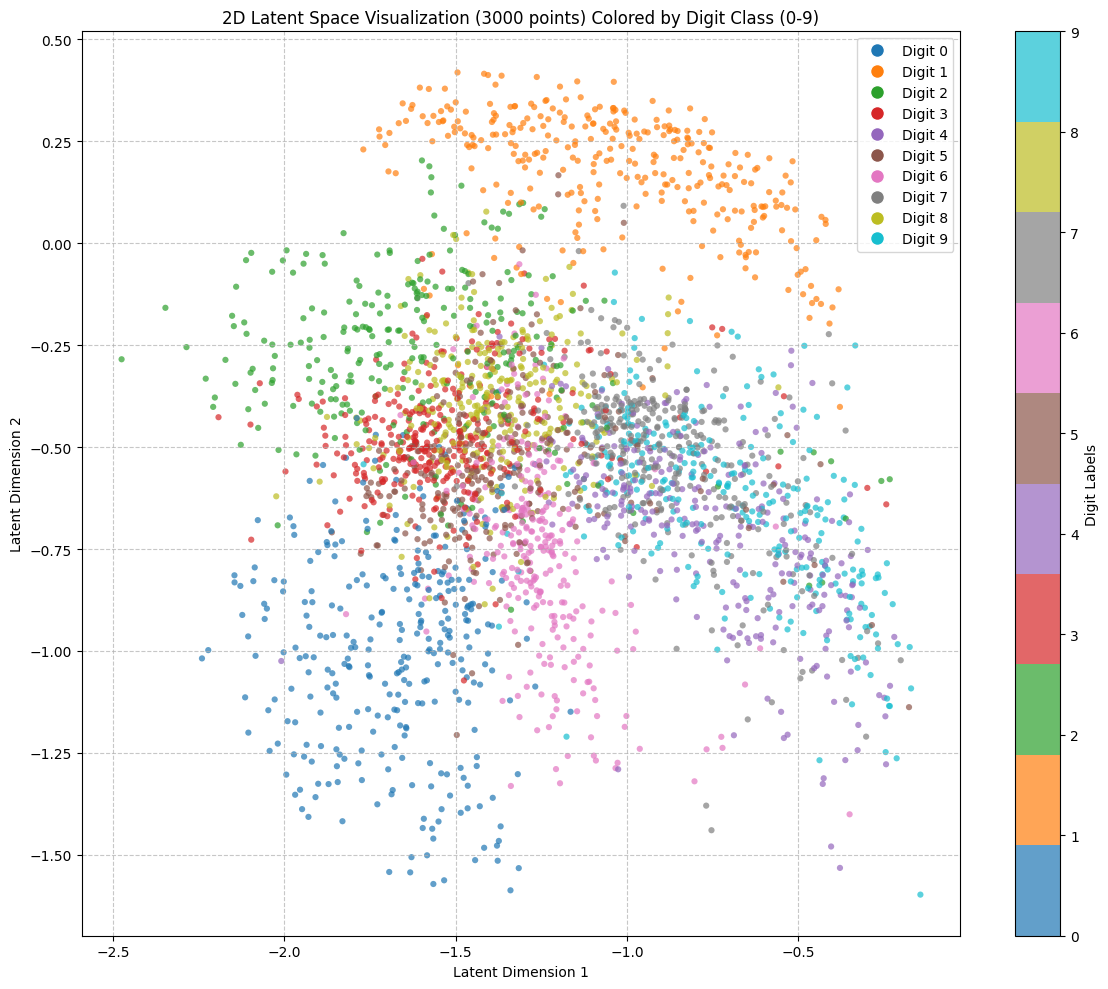

In [42]:
display_latents(ae, train_loader, device)